<div align="center">

# <span style="color: #3498db;">CA2 - Genetic & Game</span>

**<span style="color:rgb(247, 169, 0);">[Rayhaneh Einollahi]</span> - <span style="color:rgb(143, 95, 195);">
</span>**

</div>


<div style="font-family: Arial, sans-serif; line-height: 1.6;">

### 📊 Matplotlib – Data Visualization in Python  

matplotlib is a python library that is mainly used for data visualization. This library allows you to plot different type of figures including scatters and histograms. In the first part of this project you are supposed to implement a genetic algorithm. To visualize plots that are required in the project description use plotting as much as you can because it gives a great insight on what is happening during each run. It also helps you to compare your results whenevever you want to understand effect of different parameters during different runs.
For more information, check [this notebook](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/04.00-Introduction-To-Matplotlib.ipynb) and visit [the website](https://matplotlib.org/stable/tutorials/pyplot.html#sphx-glr-tutorials-pyplot-py).

In [61]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math

# <span style="color: #3498db;">Genetic Algorithm</span>

In [62]:
import random
import itertools
import numpy as np

In [ ]:
# algorithm parameters
numCoeffs = 41
populationSize = 100
generations = 200
mutationRate = 0.15
functionRange = (-np.pi, np.pi)
sampleCount = 100
A = 10

In [64]:
# These functions are given as samples to use in the algorithm
def getTargetFunction(functionName="sin_cos"):
    def sinCosFunction(t):
        """Target function: sin(2πt) + 0.5*cos(4πt)."""
        return np.sin(2 * np.pi * t) + 0.5 * np.cos(4 * np.pi * t)

    def linearFunction(t):
        """Simple linear function: y = 2t + 1."""
        return 2 * t + 1

    def quadraticFunction(t):
        """Quadratic function: y = 4t^2 - 4t + 2."""
        return 4 * (t**2) - 4 * t + 2

    def cubicFunction(t):
        """Cubic function: y = 8t^3 - 12t^2 + 6t."""
        return 8 * (t**3) - 12 * (t**2) + 6 * t

    def gaussianFunction(t):
        """Gaussian function centered at t=0.5."""
        mu = 0.5
        sigma = 0.1  # Adjust sigma to control the width of the peak
        return np.exp(-((t - mu) ** 2) / (2 * sigma**2))

    def squareWaveFunction(t):
        """Approximation of a square wave. Smoothed for better Fourier approximation."""
        return 0.5 * (np.sign(np.sin(2 * np.pi * t)) + 1)

    def sawtoothFunction(t):
        """Sawtooth wave, normalized to [0, 1]."""
        return (t * 5) % 1

    def complexFourierFunction(t):
        return (
            np.sin(2 * np.pi * t)
            + 0.3 * np.cos(4 * np.pi * t)
            + 0.2 * np.sin(6 * np.pi * t)
            + 0.1 * np.cos(8 * np.pi * t)
        )

    def polynomialFunction(t):
        return 10 * (t**5) - 20 * (t**4) + 15 * (t**3) - 4 * (t**2) + t + 0.5

    functionOptions = {
        "sin_cos": sinCosFunction,
        "linear": linearFunction,
        "quadratic": quadraticFunction,
        "cubic": cubicFunction,
        "gaussian": gaussianFunction,
        "square_wave": squareWaveFunction,
        "sawtooth": sawtoothFunction,
        "complex_fourier": complexFourierFunction,
        "polynomial": polynomialFunction,
    }

    selectedFunction = functionOptions.get(functionName.lower())
    if selectedFunction:
        return selectedFunction

<div style="color:rgb(235, 66, 32); font-weight: bold;">⚠️ Important Note:</div>  

Using **NumPy arrays** allows you to perform operations on vectors **more efficiently** and **faster**.

**Avoid using `for` loops** whenever possible, as vectorized operations in NumPy are **optimized for performance** and significantly reduce execution time.  


what are genes and chromosome in this problem?

the chromosomes are the set of 41 coefficients we have to find and each of these coefficients are the genes of the problem.

In [65]:
# generate samples
def get_samples(functionName):
    tSamples = np.linspace(functionRange[0], functionRange[1], sampleCount)
    fSamples = getTargetFunction(functionName)(tSamples)
    population = np.random.uniform(low=-A, high=A, size=(populationSize, numCoeffs))

    return tSamples, fSamples, population

In [66]:

def evaluateFourierSeries(coefs, t):
    a = coefs[:21]
    b = coefs[21:]

    n = np.arange(1, 21)
    t = np.asarray(t)
    cos_terms = a[1:] * np.cos(n * t[..., np.newaxis])
    sin_terms = b * np.sin(n * t[..., np.newaxis])

    return a[0] / 2 + np.sum(cos_terms + sin_terms, axis=-1)


In [67]:
def RMSE_fitnessEvaluation(chromo, tSamples, fSamples):
    pred = evaluateFourierSeries(chromo, tSamples)
    return np.sqrt(np.mean((fSamples - pred) ** 2))

def fitness_correlation(chromo, tSamples, fSamples):
    pred = evaluateFourierSeries(chromo, tSamples)
    mse = np.mean((fSamples - pred) ** 2) / np.var(fSamples)
    correlation = np.corrcoef(fSamples, pred)[0, 1]

    alpha = 0.5    
    return alpha * mse + (1 - alpha) * (1 - correlation)

def fitness_weighted(chromo, tSamples, fSamples, weights=None):
    pred = evaluateFourierSeries(chromo, tSamples)
    error = (pred - fSamples) ** 2
    mse = np.mean(error)

    if weights is None:
        freqs = chromo[1::2]  # Assuming these are frequency-related coefficients
        weights = np.linspace(1, 0.1, len(freqs))
    penalty = np.sum(weights * chromo[1::2]**2)  # Penalize high-frequency energy

    weighted_mse = mse + penalty
    return  (1.0 + weighted_mse)


In [68]:
#crossover
#combine two best crossovers:
def crossover(p1, p2):
    if np.random.rand() < 0.5:
        return frequency_pair_crossover(p1, p2)
    else:
        return blex_alpha_crossover(p1, p2)

def blex_alpha_crossover(p1, p2, alpha=0.5):
    c_min = np.minimum(p1, p2)
    c_max = np.maximum(p1, p2)
    diff = c_max - c_min
    lower = c_min - alpha * diff
    upper = c_max + alpha * diff
    return np.random.uniform(lower, upper)

# my idea: if we have chosen a gene from a parent there is a higher
# probability that for the next gene to be chosen from that parent:
def frequency_pair_crossover(p1, p2, p_switch=0.3):
    n = (len(p1) - 1) // 2
    child = np.empty_like(p1)
    
    # a₀ is special
    child[0] = p1[0] if np.random.rand() < 0.5 else p2[0]
    current_parent = p1 if child[0] == p1[0] else p2
    
    for k in range(1, n + 1):
        base = np.random.rand() < p_switch
        if base:
            current_parent = p1 if current_parent is p2 else p2
        child[k] = current_parent[k]
        child[n + k] = current_parent[n + k]
    return child

In [69]:
#----------------------------------other crossovers----------------------------------------------
def arithmetic_crossover(parent1, parent2):
    alpha = np.random.uniform(0.2, 0.8)
    child = alpha * parent1 + (1-alpha) * parent2    
    return child

def gaussian_weighted_crossover(p1, p2, sigma=0.2):
    child = np.empty_like(p1)
    for i in range(len(p1)):
        weight = np.random.normal(1, sigma) 
        weight = max(0, min(weight, 1))
        child[i] = weight * p1[i] + (1 - weight) * p2[i]
    return child


def polynomial_crossover(p1, p2, eta=1.0):
    child = np.empty_like(p1)
    for i in range(len(p1)):
        rand = np.random.rand()
        beta = 1 + (2 * (rand - 0.5)) * eta
        child[i] = beta * p1[i] + (1 - beta) * p2[i]
    return child

def grouped_arithmetic_crossover(p1, p2, alpha=0.5):
    n = (len(p1) - 1) // 2
    a_part = alpha * p1[:n+1] + (1 - alpha) * p2[:n+1]
    b_part = alpha * p1[n+1:] + (1 - alpha) * p2[n+1:]
    return np.concatenate([a_part, b_part])

def uniform_crossover(p1, p2):
    mask = np.random.rand(len(p1)) < 0.5
    child = np.where(mask, p1, p2)
    return child

In [70]:
def mutate(chromo, gen, max_generations):
    if np.random.rand() < gen/max_generations:
        return gaussian_mutation(chromo, (1 - (gen/generations))*0.1)
        return gaussian_mutation(chromo)
    else:
        return rotation_mutation(chromo, gen, max_generations)

#excelent
def rotation_mutation(chromo, gen, max_generations, initial_mutation_rate=0.3, final_mutation_rate=0.05):
    mutation_rate = initial_mutation_rate - (initial_mutation_rate - final_mutation_rate) * (gen/max_generations)
    child = chromo.copy()
    if np.random.rand() < mutation_rate:
        k = np.random.randint(1, len(chromo))
        child = np.roll(child, k)
    return child

def gaussian_mutation(chromo, scale=0.05,mutation_rate = 0.1 ):

    mask = np.random.rand(len(chromo)) < mutation_rate
    noise = np.random.normal(0, scale, size=len(chromo))
    return chromo + mask * noise

def my_mutate(chromo, gen, max_generations, initial_mutation_rate=0.25, final_mutation_rate=0.05):
    mutated = np.copy(chromo)
    n_coeffs = len(chromo)
    
    # Adaptive mutation rate (decreases over generations)
    mutation_rate = initial_mutation_rate - (initial_mutation_rate - final_mutation_rate) * (gen/max_generations)
    # Different mutation strategies for different coefficient types
    for i in range(n_coeffs):
        if np.random.rand() < mutation_rate:
            # DC component (a0) gets special treatment
            if i == 0:
                mutated[i] += np.random.normal(0, 0.1)  # Small Gaussian perturbation
            else:
                # For harmonic coefficients, scale mutation by frequency
                harmonic_order = (i + 1) // 2
                mutation_strength = 0.2 / harmonic_order  # Higher frequencies get smaller mutations
                
                if np.random.rand() < 0.7:  # 70% chance of Gaussian mutation
                    mutated[i] += np.random.normal(0, mutation_strength)
                else:  # 30% chance of completely new value
                    mutated[i] = np.random.uniform(-1, 1) * mutation_strength * 5
                    
    # Ensure coefficients don't explode
    mutated = np.clip(mutated, -10, 10)  # Keep within reasonable bounds
    
    return mutated


#very good
def creep_mutation(p, mutation_rate=0.1, step_size=0.05):
    child = p.copy()
    for i in range(len(p)):
        if np.random.rand() < mutation_rate:
            child[i] += np.random.choice([-1, 1]) * np.random.uniform(0, step_size)
    return child

def swap_mutation(p, mutation_rate=0.1):
    child = p.copy()
    for i in range(1, len(p) // 2):
        if np.random.rand() < mutation_rate:
            idx1, idx2 = np.random.choice(range(1, len(p)//2), 2, replace=False)
            child[idx1], child[idx2] = child[idx2], child[idx1]
            child[len(p)//2 + idx1], child[len(p)//2 + idx2] = child[len(p)//2 + idx2], child[len(p)//2 + idx1]
    return child

In [71]:
def sortPopulation(fitnessEvaluation, pop, tSamples, fSamples):
    return pop[np.argsort(np.apply_along_axis(fitnessEvaluation, 1, pop, tSamples, fSamples))]


In [72]:
def getParents(population, choiceSize):
    n = len(population)
    total = (1 + n) * n / 2
    probs = np.array([(n-i) / total for i in range(n)])
    selected_indices = np.random.choice(n, size=choiceSize, p=probs, replace=True) 
    return population[selected_indices]

In [73]:
def genetic_algorithm(functionName, ax, fitnessEvaluation):
    tSamples, fSamples, population = get_samples(functionName)
    for gen in range(generations):
        population = sortPopulation(fitnessEvaluation, population, tSamples, fSamples)
        parents = getParents(population, 2*populationSize)
        new_generation = np.empty_like(population)
        for i in range(populationSize):
            child = crossover(parents[i], parents[i+populationSize])
            new_generation[i]= child

        y = np.array([evaluateFourierSeries(population[0],t) for t in tSamples])
        color = cm.Greens(gen/generations)
        if gen == generations - 1:
            color = "red"
            ax.plot(tSamples, y,color=color)

        new_generation[:int(populationSize*0.1)] = population[:int(populationSize*0.1)]
        for i in range(int(populationSize*0.1),populationSize):
            new_generation[i] = mutate(new_generation[i], gen, generations)
        population = new_generation

    ax.plot(tSamples, fSamples, color = "blue")

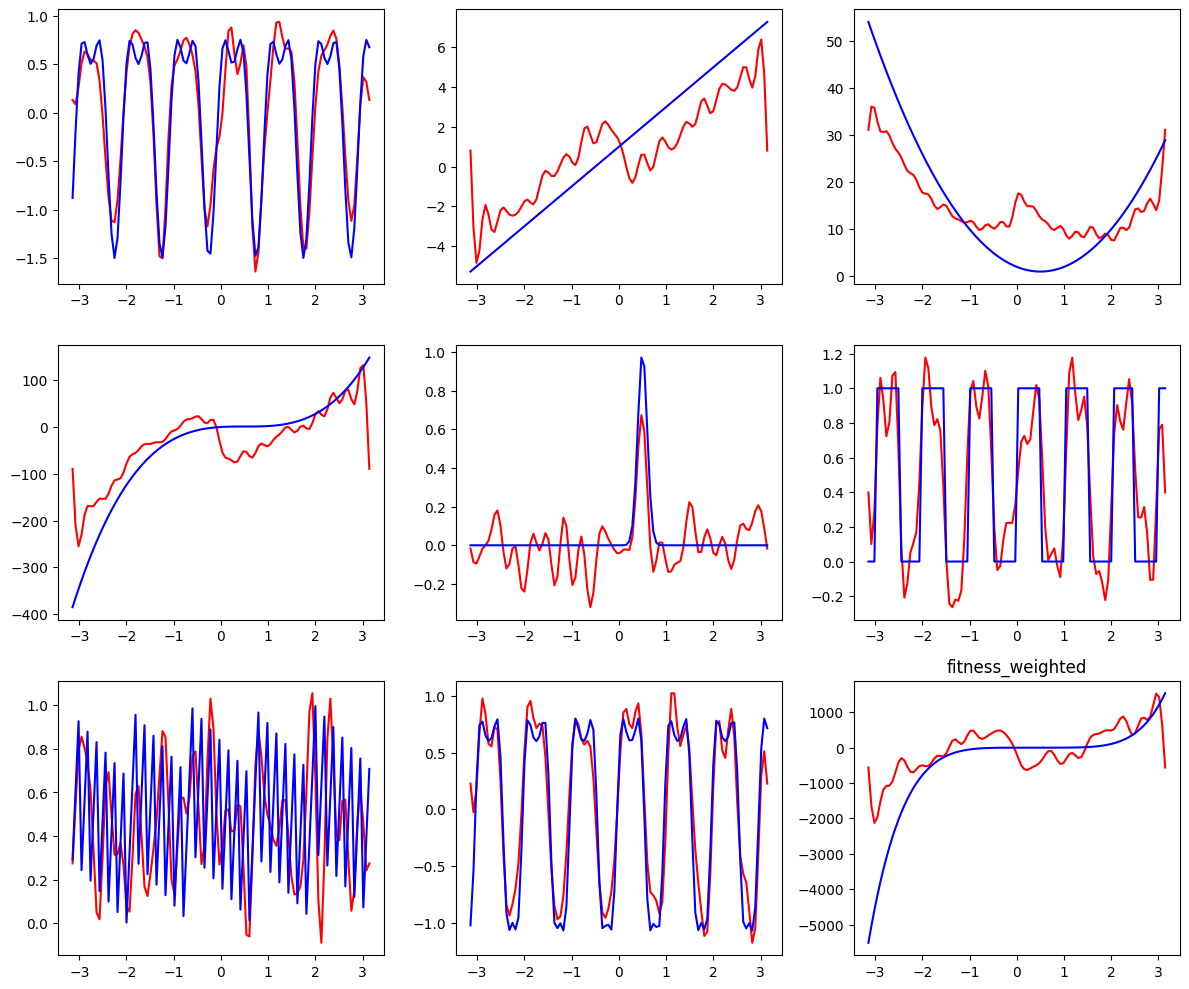

In [74]:
functions = ["sin_cos", "linear", "quadratic", "cubic", "gaussian", "square_wave", "sawtooth", "complex_fourier", "polynomial"]

fig, axs = plt.subplots(3, 3, figsize=(12, 10))
axs = axs.flatten()

for i, f in enumerate(functions):
    ax = axs[i]
    genetic_algorithm(f, ax, fitness_weighted)

plt.title("fitness_weighted")
plt.tight_layout()
plt.show()



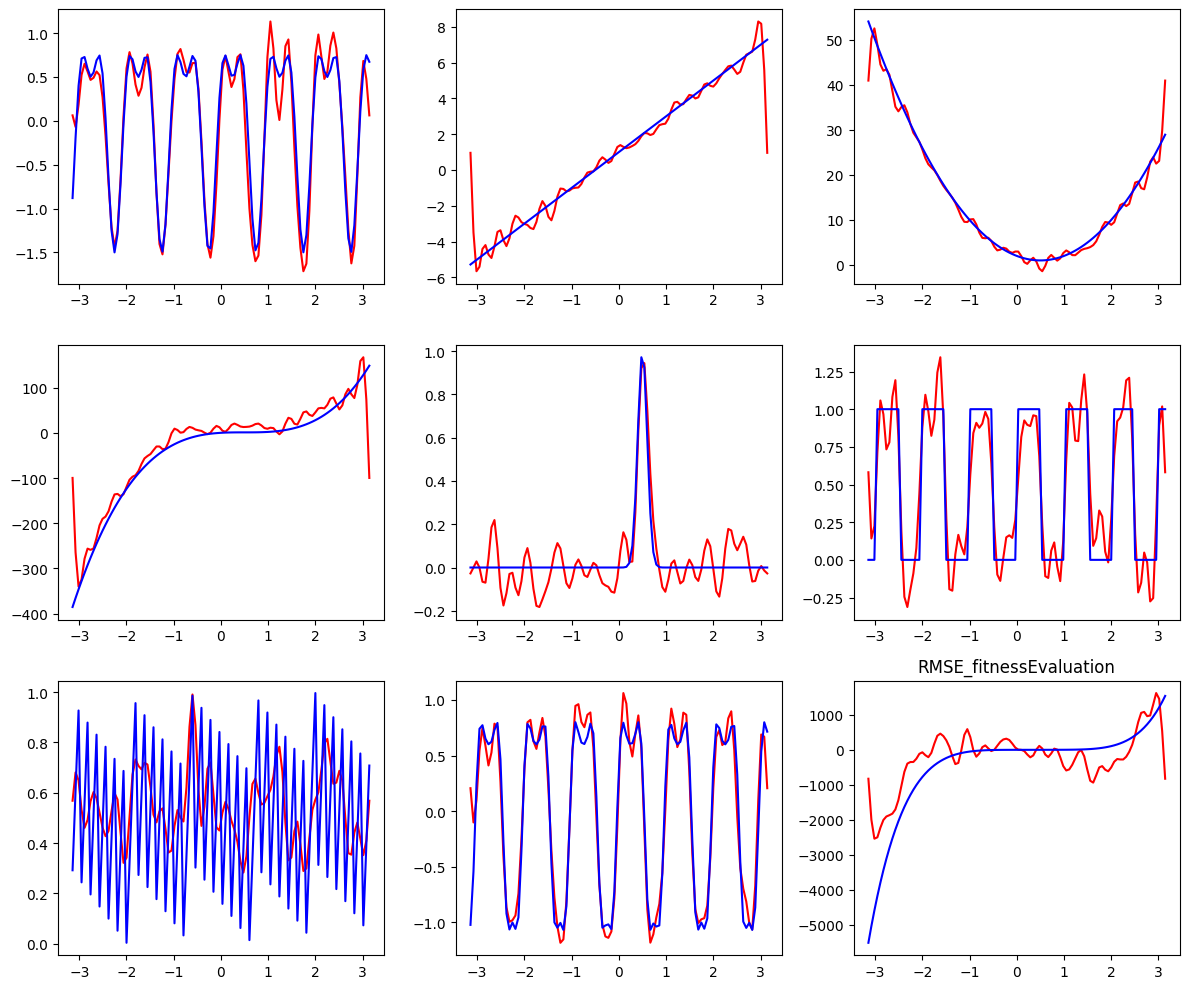

In [75]:
fig, axs = plt.subplots(3, 3, figsize=(12, 10))
axs = axs.flatten()

for i, f in enumerate(functions):
    ax = axs[i]
    genetic_algorithm(f, ax, RMSE_fitnessEvaluation)

plt.title("RMSE_fitnessEvaluation")
plt.tight_layout()
plt.show()

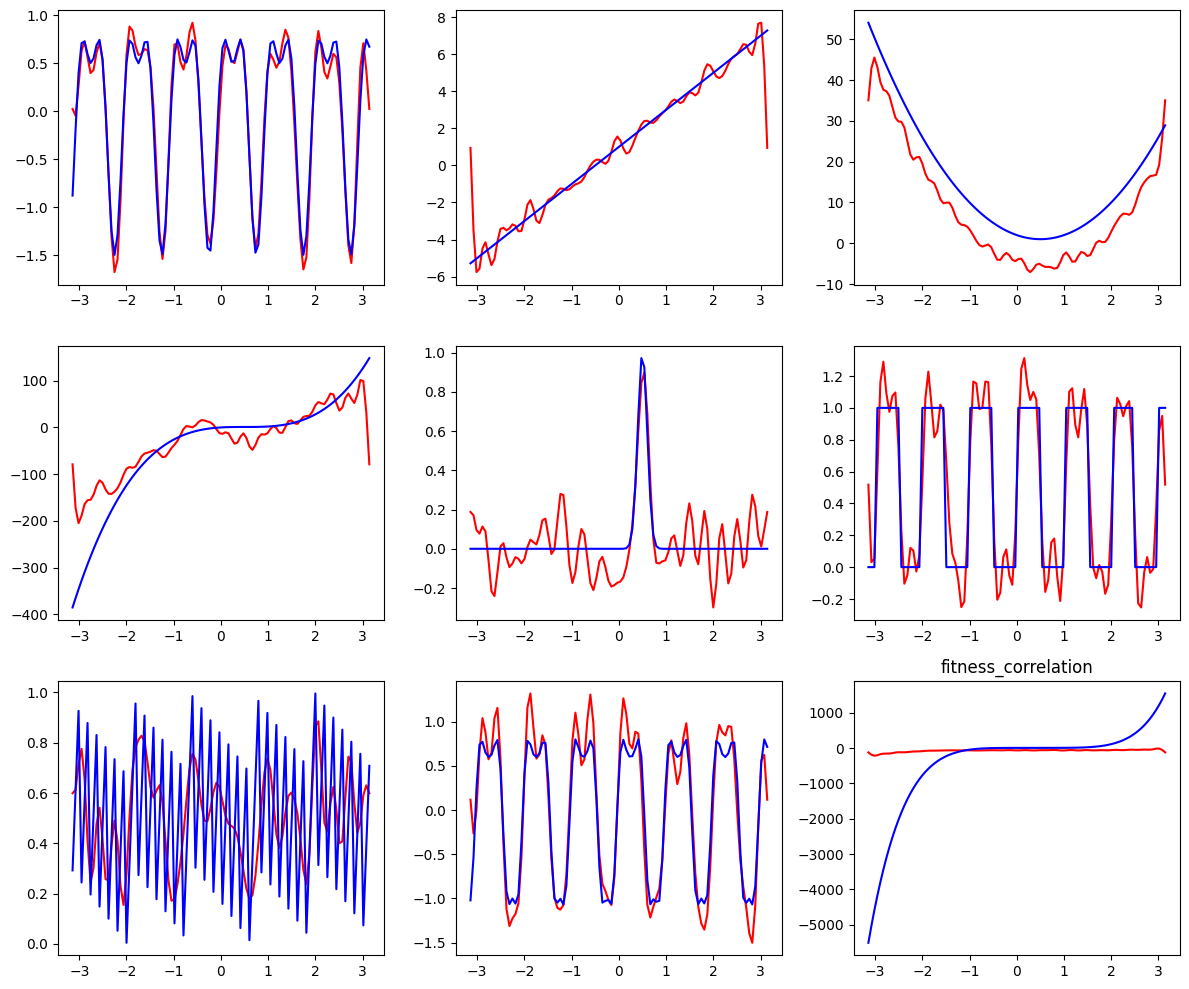

In [76]:
fig, axs = plt.subplots(3, 3, figsize=(12, 10))
axs = axs.flatten()

for i, f in enumerate(functions):
    ax = axs[i]
    genetic_algorithm(f, ax, fitness_correlation )

plt.title("fitness_correlation")
plt.tight_layout()
plt.show()

# Report:

## **Question 1**  
what is the space of the chromosomes?


it's the coefficients of the fourier series that are at first from -A to +A but overtime they get different values more or less than these

## **Question 2**  
what can make the converging faster in this algorithm?

if we increase the number of samples for high frequncy functions and reduce it for low frequency ones that could lead to a better aproximation

we can also combine different crossover and mutation algorithms together that would change the population to explore new things

## **Question 3**  
what are the strategies to select the next generation?

we can take different percent of the elite,
in crossover return two childs or one child,
first mutaue then crossover or the other way

## **Question 4**  
how to stop the algorithm from converging too fast?

we can reduce the elite size and make mutation rates higher


## **Question 5** 

**R-squared**, or the **coefficient of determination**, quantifies how well a regression model explains the variance in the dependent variable. It measures the proportion of variance in the observed data that is predictable from the model.

## Formula
$$
R^2 = 1 - \frac{SS_{res}}{SS_{tot}}
$$

Where:
- **SS<sub>res</sub>** = Sum of squared residuals (errors between predicted and actual values).
- **SS<sub>tot</sub>** = Total sum of squares (variance in the observed data).

## Interpretation
- **1.0**: Perfect fit (model explains 100% of variance).
- **0.0**: Model explains none of the variance (no better than the mean).
- **< 0**: Model performs worse than a horizontal line (rare).


Yes, because if we want a normalized, unitless score instead of RMSE it would work better, as it's between 0, 1